<img src="../source/_static/images/vspec_logo.png" alt="VSPEC Logo" width=400px />

# VSPEC: Variable Star PhasE Curve

## A python package to simulate Planetary Infrared Excess (PIE) observations of rocky planets around variable M dwarfs

#### Cameron Kelehan and Ted Johnson

VSPEC uses a dynamic model of stellar spots, faculae, and flares combined with simultations from the Planetary Spectrum Generator (PSG, [Villanueva et al., 2018](https://ui.adsabs.harvard.edu/abs/2018JQSRT.217...86V/abstract)) to simulate phase resolved observations of planetary thermal emission spectra. This package was designed for the Mid-IR Exoplanet CLimate Explorer mission concept (MIRECLE, [Mandell et al., 2022](https://ui.adsabs.harvard.edu/abs/2022AJ....164..176M/abstract)), but was built to be used more generally.

The primary goal of this software is to simulate combined planet-host spectra in order to develop techniques to remove the star using the Planetary Infrared Excess (PIE) technique. For more info on PIE, see [Stevenson (2020)](https://ui.adsabs.harvard.edu/abs/2020ApJ...898L..35S/abstract) and [Lustig-Yaeger et al. (2021)](https://ui.adsabs.harvard.edu/abs/2021ApJ...921L...4L/abstract).

### Installation

For now it is best to install via pip from our github repository. In the future,
stable versions will be on PyPI.

`pip install git+https://github.com/VSPEC-collab/VSPEC.git@main`

You can also clone this repository, especially if you are interested in contributing.

`git clone https://github.com/VSPEC-collab/VSPEC.git`

`cd VSPEC`

`pip install -e .`

### Using VSPEC

#### Quick start guide

The parameters of a VSPEC model are specified in a configuration file. Before we run the model we will read these parameters into memory. The fundamental object in VSPEC is `VSPEC.ObservationalModel`.

In [1]:
import VSPEC
from pathlib import Path
import matplotlib.pyplot as plt
from astropy import units as u
import numpy as np

In [20]:
config_path = '../../test/default.cfg'
model = VSPEC.ObservationModel(config_path)

The GCM we will use is located here:

In [3]:
print(Path(config_path).parent / 'test_gcms/modernearth.gcm')

../test/test_gcms/modernearth.gcm


This created a new directory called `example_star/` that will store all the data from this model run.

Let's look at where our model parameters are stored. For example we can look at the effective temperature of quiet photosphere.

In [33]:
print(model.params.star_teff)

3300.0 K


Now we need to bin the spectra to the desired resolution. In the configureation file we specified:

In [5]:
print(f'starting wavelength = {model.params.lambda_min}')
print(f'ending wavelength = {model.params.lambda_max}')
print(f'resolving power = {model.params.resolving_power}')

starting wavelength = 1.0 um
ending wavelength = 18.0 um
resolving power = 50.0


We can ask the model to bin spectra from a grid of PHOENIX models. The $T_{eff}$ range is specified in the configuration file.

In [6]:
model.bin_spectra()

Binning Spectra:   0%|          | 0/12 [00:00<?, ?it/s]

Now we make a series of API calls to PSG to retrive spectra of the planet model. The configuration file specifies a GCM file that is uploaded to PSG in `model.params.gcm_file_path`.

I am running PSG locally using Rancher Desktop. To run PSG on your machine there are detailed instructions in the [PSG handbook](https://psg.gsfc.nasa.gov/help.php#handbook). It is very easy and allows you to avoid the need for an API key.

In [7]:
model.build_planet()

Starting at phase 180.0 deg, observe for 10.0 d in 20 steps
Phases = [180.   198.95 217.89 236.84 255.79 274.74 293.68 312.63 331.58 350.53
   9.47  28.42  47.37  66.32  85.26 104.21 123.16 142.11 161.05 180.  ] deg


Build Planet:   0%|          | 0/20 [00:00<?, ?it/s]

Lastly, we need to run our variable star model. PSG uses its own stellar templates, but we will replace those with our own model. This allows us to accurately model the affect that variability has on reflected light as well as noise. We will more finely sample the time over which we observe because the star can change much faster than the planet.

In [8]:
model.build_spectra()

Generated 39 mature spots


Build Spectra:   0%|          | 0/480 [00:00<?, ?it/s]

#### Analysis

All of our data produced by this model run is stored in `example_star/Data/AllModelSpectraValues`. We can store that data in the `PhaseAnayzer` object.

In [2]:
data_path = Path('default/Data/AllModelSpectraValues')
sim_data = VSPEC.PhaseAnalyzer(data_path)

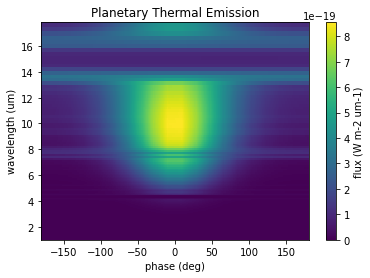

In [6]:
plt.pcolormesh(VSPEC.helpers.to_float(sim_data.unique_phase-360*u.deg,u.deg),
                VSPEC.helpers.to_float(sim_data.wavelength,u.um),
                VSPEC.helpers.to_float(sim_data.thermal,u.Unit('W1m-2um-1')))
plt.xlabel('phase (deg)')
plt.ylabel('wavelength (um)')
plt.title('Planetary Thermal Emission')
cbar = plt.colorbar()
cbar.set_label('flux (W m-2 um-1)')

#### NOTE: this code uses the PSG convention for planet phase. Primary transit occurs at phase = 180 deg, and secondary ecllipse occurs at phase = 0 deg (for planets that transit).

We can also create lightcurves

Text(0.5, 1.0, 'Source total with\nbandpass from 1.0 um to 2.164745 um')

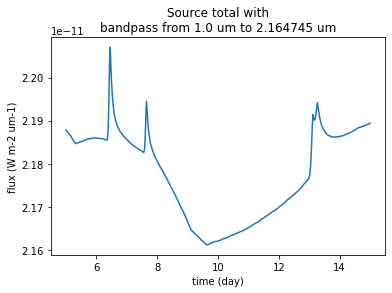

In [9]:
pixel = (0,40)
bandpass = sim_data.wavelength[slice(*pixel)]
plt.plot(sim_data.time.to(u.day), sim_data.lightcurve('total',pixel))
plt.xlabel('time (day)')
plt.ylabel('flux (W m-2 um-1)')
plt.title(f'Source total with\nbandpass from {bandpass.min()} to {bandpass.max()}')

Text(0.5, 1.0, 'thermal with\nbandpass from 10.76516 um to 17.66139 um')

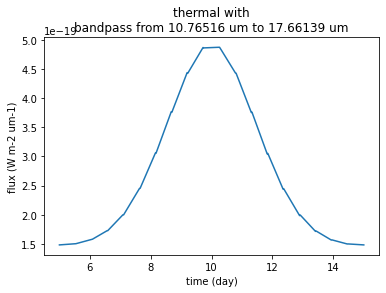

In [10]:
pixel = (120,150)
bandpass = sim_data.wavelength[slice(*pixel)]
plt.plot(sim_data.time.to(u.day),sim_data.lightcurve('thermal',pixel))
plt.xlabel('time (day)')
plt.ylabel('flux (W m-2 um-1)')
plt.title(f'thermal with\nbandpass from {bandpass.min()} to {bandpass.max()}')

Text(0.5, 1.0, 'Reflected with\nbandpass from 1.0 um to 2.164745 um')

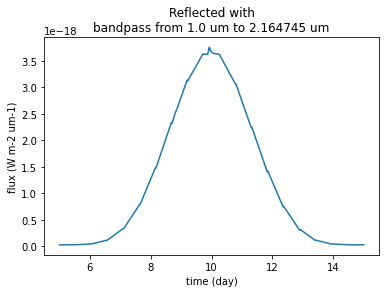

In [11]:
pixel = (0,40)
bandpass = sim_data.wavelength[slice(*pixel)]
plt.plot(sim_data.time.to(u.day),sim_data.lightcurve('reflected',pixel))
plt.xlabel('time (day)')
plt.ylabel('flux (W m-2 um-1)')
plt.title(f'Reflected with\nbandpass from {bandpass.min()} to {bandpass.max()}')

We can also look at the spectra produced at each phase step and combine multiple steps to improve SNR. The code below creates a figure that shows the system geometry, the thermal profile, and the spectrum with error envelope

In [15]:
sim_data.get_layer('Temp')

<Quantity [[189.026     , 196.586     , 225.905     , ..., 185.426     ,
            182.403     , 181.744     ],
           [189.07121921, 196.61418372, 225.88558455, ..., 185.42378706,
            182.39581837, 181.73669311],
           [189.11643841, 196.64236743, 225.8661691 , ..., 185.42157411,
            182.38863674, 181.72938622],
           ...,
           [189.06638545, 196.6253048 , 225.94192737, ..., 185.42454884,
            182.40917515, 181.75604153],
           [189.01177167, 196.5721524 , 225.89199   , ..., 185.42651126,
            182.40082441, 181.73975761],
           [189.026     , 196.586     , 225.905     , ..., 185.426     ,
            182.403     , 181.744     ]] K>

In [25]:
i=0
binning = 50
def makefig(i):
    # plt.style.use('dark_background')
    fig,ax = plt.subplots(1,2,figsize=(10,5))
    # color = cm.viridis(np.cos(data.unique_phase[i])*0.5 + 0.5)
    color = 'k'
    sli = (max(0,i-binning),min(sim_data.N_images,i+binning))
    ax[0].plot(sim_data.get_layer('Temp')[i,:],sim_data.get_layer('Pressure')[i,:],c=color)
    ax[0].set_yscale('log')
    ylim = ax[0].get_ylim()

    ax[0].text(210,5e-5,f'phase={sim_data.unique_phase[i].value - 360:.1f} deg',fontsize=14,fontfamily='serif')

    ax[0].set_ylim(ylim[1],ylim[0])
    ax[0].set_xlim(150,292)
    ax[0].set_ylabel('Pressure (bar)',fontsize=14,fontfamily='serif')
    ax[0].set_xlabel('Temperature (K)',fontsize=14,fontfamily='serif')

    inax = ax[0].inset_axes([0.5,0.3,0.4,0.4])
    inax.set_aspect(1)
    inax.scatter(0,0,c='xkcd:tangerine',s=150)
    
    theta = np.linspace(0,360,180,endpoint=False)*u.deg
    r_dist = (1-model.params.planet_eccentricity**2)/(1+model.params.planet_eccentricity*np.cos(theta- model.params.system_phase_of_periasteron - 90*u.deg))
    curr_theta = sim_data.phase[i] + 90*u.deg
    x_dist = model.params.planet_semimajor_axis * np.cos(theta)*r_dist
    y_dist = model.params.planet_semimajor_axis * np.sin(theta)*r_dist*np.cos(model.params.system_inclination)
    current_r = (1-model.params.planet_eccentricity**2)/(1+model.params.planet_eccentricity*np.cos(curr_theta- model.params.system_phase_of_periasteron - 90*u.deg))
    current_x_dist = model.params.planet_semimajor_axis * np.cos(curr_theta)*current_r
    current_y_dist = model.params.planet_semimajor_axis * np.sin(curr_theta)*current_r*np.cos(model.params.system_inclination)
    behind = np.sin(theta) >= 0
    x_angle = np.arctan(x_dist/model.params.system_distance).to(u.mas)
    y_angle = np.arctan(y_dist/model.params.system_distance).to(u.mas)
    plotlim = np.arctan(model.params.planet_semimajor_axis/model.params.system_distance).to(u.mas).value * (1+model.params.planet_eccentricity)*1.05
    current_x_angle = np.arctan(current_x_dist/model.params.system_distance).to(u.mas)
    current_y_angle = np.arctan(current_y_dist/model.params.system_distance).to(u.mas)
    z_order_mapper = {True:-99,False:100}
    inax.plot(x_angle[behind],y_angle[behind],zorder=-100,c='C0',alpha=1,ls=(0,(2,2)))
    inax.plot(x_angle[~behind],y_angle[~behind],zorder=99,c='C0')
    inax.scatter(current_x_angle,current_y_angle,zorder = z_order_mapper[np.sin(curr_theta) >= 0],c='k')
    inax.set_xlim(-plotlim,plotlim)
    inax.set_ylim(-plotlim,plotlim)
    inax.set_xlabel('sep (mas)')
    inax.set_ylabel('sep (mas)')


    contrast = sim_data.spectrum('thermal',sli)/sim_data.spectrum('total',sli)
    noise = sim_data.spectrum('noise',sli)/sim_data.spectrum('total',sli)
    ax[1].plot(sim_data.wavelength,contrast*1e6,c=color)
    ax[1].fill_between(sim_data.wavelength.value,(contrast + noise)*1e6,(contrast-noise)*1e6,color='k',alpha=0.3)
    ax[1].set_ylim(-1,100)
    ax[1].set_ylabel('Contrast (ppm)',fontsize=14,fontfamily='serif')
    ax[1].set_xlabel('Wavelength ($\mu$m)',fontsize=14,fontfamily='serif')
    plt.style.use('default')
    return fig


/var/folders/b4/9tq5p8g95dl0144rmgktxrvh0000gp/T/ipykernel_93570/1612521938.py:1: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  makefig(300).show()


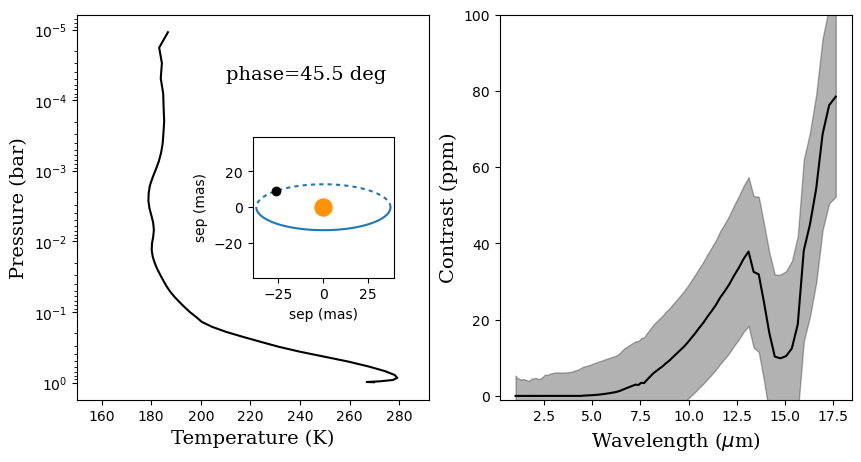

In [32]:
makefig(300).show()

/var/folders/b4/9tq5p8g95dl0144rmgktxrvh0000gp/T/ipykernel_93570/1915159874.py:1: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  makefig(60).show()


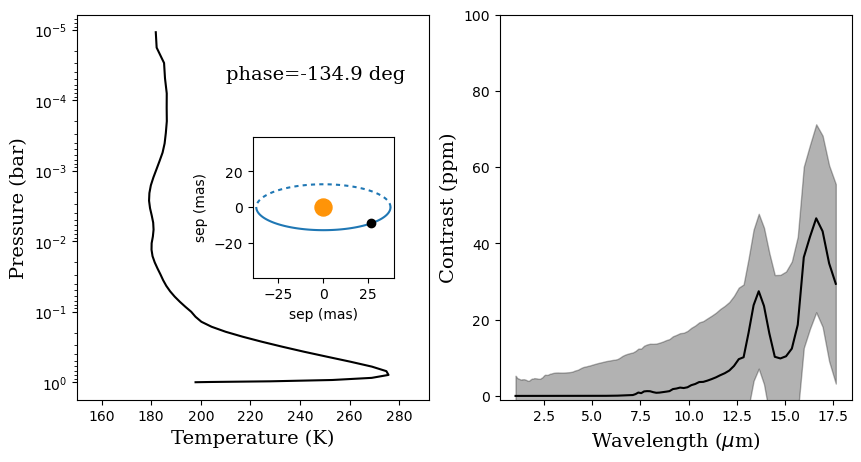

In [27]:
makefig(60).show()

Text(0, 0.5, 'wavelength (um)')

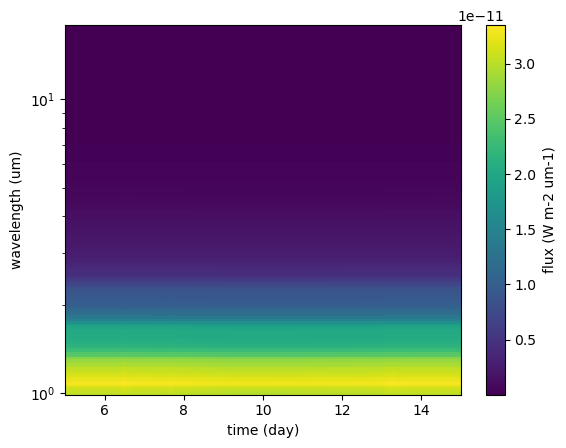

In [31]:
plt.pcolormesh(VSPEC.helpers.to_float(sim_data.time,u.day),
                VSPEC.helpers.to_float(sim_data.wavelength,u.um),
                VSPEC.helpers.to_float(sim_data.total,u.Unit('W m-2 um-1')))
plt.colorbar(label='flux (W m-2 um-1)')
plt.yscale('log')
plt.xlabel('time (day)')
plt.ylabel('wavelength (um)')